# Rule Optimiser (unlabelled) Example

This notebook contains an example of how the Rule Optimiser module can be used to optimise the thresholds of an existing set of rules, given an **unlabelled** dataset.

The Rule Optimiser is able to interpret and optimise rules with the following characteristics:

### As in ARGO v1
* Conditions joined with the AND operator
* Numeric conditions with the following operators:
    - Greater than (or equal to)
    - Less than (or equal to)
    - Equal
    - Not equal

### New in ARGO v2
* Nested conditions
* Conditions joined with the OR operator
* Conditions that employ the following operators (and all complimentary NOT versions):
    - begins with 
    - ends with 
    - contains 
    - is in
    - is empty 
    - is null 
    - field comparisons

#### Note that non-numeric thresholds aren't optimised, but they are considered as part of the rule’s logic. For example, a rule such as *order_amount>500* & *ip_country=='US'* will only optimise the threshold of the *order_amount* condition, but will consider the *ip_country=='US'* condition when optimising the *order_amount* condition.

## Requirements

To run, you'll need the following:

* Install the Rule Optimisation package - see the readme for more information.
* A rule set stored in the standard ARGO lambda expression format, along with the keyword arguments for each lambda expression (more information on how to do this later)
* An unlabelled dataset containing the features present in the rule set.

----

## Import packages

In [2]:
from rule_optimisation.rule_optimiser import RuleOptimiser
from rules.rules import Rules
from rule_application.argo_rule_applier import ArgoRuleApplier

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

## Read in data

Firstly, we need to read in the raw data containing the features:

In [3]:
data = pd.read_csv('dummy_data/dummy_pipeline_output_data.csv', index_col='eid')

Then we can split the dataset into training and test sets:

In [4]:
X_train, X_test = train_test_split(data, test_size=0.33, random_state=0)

## Read in system-ready rule conditions

In this example, we'll read in the rule conditions from a pickle file. However, in practise, it's likely that you'll need to fetch the rule conditions from a Simility environment. See the *ReturnRuleConditionsFromSimility* class in the *rule_requests* module of the *simility_requests* sub-package for more information.

In [5]:
import pickle
with open('dummy_data/rule_system_conditions.pkl', 'rb') as f:
    rule_system_conditions = pickle.load(f)

Now that we have the system-ready rule conditions, we need to convert them to the standard ARGO lambda expression format. This format allows new threshold values to be injected into the rule condition before being evaluated - this is how the rule optimiser finds the optimal threshold values:

In [6]:
rules = Rules(system_dicts=rule_system_conditions)

In [7]:
rule_lambdas = rules.as_rule_lambdas(as_numpy=False, with_kwargs=True)

/Users/jlaidler/venvs/rule_optimisation/lib/python3.7/site-packages/rules/convert_system_dicts_to_rule_dicts.py:79: UserWarning: JavaEL : Operator `java_el` is not currently supported in ARGO. Rule cannot be parsed.
  warnings.warn(f'{rule_name} : {e}')


By converting the rule conditions to the standard ARGO lambda expression format, we also generate a dictionary which gives the keyword arguments to each lambda expression (this dictionary is saved as the class attribute *lambda_kwargs*). Using these keyword arguments as inputs to the lambda expressions will convert them into the standard ARGO string format.

**Note that there was one rule that could not be converted into the standard ARGO lambda expression format, as it contains an unsupported operator. The list of rule names that could not be converted are stored in the class attribute *unparsed_rules*:**

In [8]:
rules.unparsed_rules

['JavaEL']

----

## Optimise rules

### Set up class parameters

Now we can set our class parameters for the Rule Optimiser. Here we're using the *.fit()* method from the *AlertsPerDay* class, which calculates the negative squared difference between the daily number of records a rule flags vs the targetted daily number of records flagged. This means that when the rule optimiser comes to maximise this metric, it will try to minimise the difference between the actual number of records flagged and the targetted number of records flagged.

See the *optimisation_functions_example* example notebook in this sub-package for more information on additional optimisation functions that can be used on unlabelled datasets.

**Please see the class docstring for more information on each parameter.**

In [9]:
from rule_optimisation.optimisation_functions import AlertsPerDay
apd = AlertsPerDay(n_alerts_expected_per_day=10, no_of_days_in_file=10)

In [10]:
params = {
    'rule_lambdas': rule_lambdas,
    'lambda_kwargs': rules.lambda_kwargs,
    'opt_func': apd.fit,
    'n_iter': 30,
    'show_progressbar': True
}

### Instantiate class and run fit method

Once the parameters have been set, we can run the *.fit()* method to optimise the rules.

In [11]:
ro = RuleOptimiser(**params)
opt_rule_strings = ro.fit(X=X_train)

100%|██████████| 30/30 [00:00<00:00, 128.27trial/s, best loss: 1.0]


### Outputs

The *.fit()* method returns a dictionary of optimised rules stored in the standard ARGO string format (values) and their names (keys). It also creates the following attributes:

* opt_rule_strings (dict): The optimised rules stored in the standard ARGO string format (values) and their names (keys).
* rule_names_missing_features (list): Names of rules which use features that are not present in the dataset (and therefore can't be optimised or applied).
* rule_names_no_opt_conditions (list): Names of rules which have no optimisable conditions (e.g.rules that only contain string-based conditions).
* rule_names_zero_var_features (list): Names of rules which exclusively contain zero variance features (based on `X`), so cannot be optimised.
* rules (object): Class containing the optimised rules stored in the standard ARGO string format. Methods from this class can be used to convert the rules into other representations. See the rules module for more information.
* opt_rule_performances (dict): The optimisation metric (values) calculated for each optimised rule (keys).
* orig_rule_performances (dict): The optimisation metric (values) calculated for each original rule (keys).

In [12]:
opt_rule_strings

{'RGDT_Rule137': "((X['account_number_avg_order_total_per_account_number_7day']<=235.77924922263912)|(X['account_number_avg_order_total_per_account_number_7day'].isna()))&(X['account_number_num_fraud_transactions_per_account_number_1day']>=1)&(X['account_number_num_fraud_transactions_per_account_number_90day']>=1)&((X['account_number_sum_order_total_per_account_number_1day']<=3273.978958931867)|(X['account_number_sum_order_total_per_account_number_1day'].isna()))",
 'RGDT_Rule81': "(X['account_number_avg_order_total_per_account_number_1day']>729.0157066766448)&(X['account_number_num_fraud_transactions_per_account_number_lifetime']>=0)&((X['account_number_num_order_items_per_account_number_30day']<=5)|(X['account_number_num_order_items_per_account_number_30day'].isna()))&((X['account_number_sum_order_total_per_account_number_1day']<=2496.2529968931435)|(X['account_number_sum_order_total_per_account_number_1day'].isna()))",
 'HighFraudTxnPerAccountNum': "(X['account_number_num_fraud_tran

---

## *Aside - improved coverage*

To highlight the improvements made in the new version of the Rule Optimiser, let's first look at the conditions for the rule named *ComplicatedRule*:

In [13]:
rules.rule_dicts['ComplicatedRule']

{'condition': 'AND',
 'rules': [{'field': 'num_order_items', 'operator': 'greater', 'value': 5.0},
  {'condition': 'OR',
   'rules': [{'condition': 'AND',
     'rules': [{'field': 'order_total',
       'operator': 'greater',
       'value': 1000.0},
      {'field': 'is_existing_user', 'operator': 'equal', 'value': True}]},
    {'condition': 'AND',
     'rules': [{'field': 'order_total', 'operator': 'greater', 'value': 500.0},
      {'field': 'is_existing_user', 'operator': 'equal', 'value': False}]},
    {'condition': 'OR',
     'rules': [{'field': 'billing_city',
       'operator': 'begins_with',
       'value': 'B'}]}]}]}

This rule contains all of the characteristics that the new Rule Optimiser covers:

* Nested conditions
* Conditions joined with the OR operator
* A complex operator (in this case, *begins with*)

Now, if we look at the optimised version of the rule, we can see that the threshold values of the numeric conditions have been optimised:

In [14]:
opt_rule_dicts = ro.rules.as_rule_dicts()
opt_rule_dicts['ComplicatedRule']

{'condition': 'AND',
 'rules': [{'field': 'num_order_items', 'operator': 'greater', 'value': 2.0},
  {'condition': 'OR',
   'rules': [{'condition': 'AND',
     'rules': [{'field': 'order_total',
       'operator': 'greater',
       'value': 1816.1469372400325},
      {'field': 'is_existing_user', 'operator': 'equal', 'value': True}]},
    {'condition': 'AND',
     'rules': [{'field': 'order_total',
       'operator': 'greater',
       'value': 191.04029715550308},
      {'field': 'is_existing_user', 'operator': 'equal', 'value': False}]},
    {'field': 'billing_city', 'operator': 'begins_with', 'value': 'B'}]}]}

By comparing the performance (in this case, the negative squared difference between the daily number of records a rule flags vs the targetted daily number of records flagged) before and after optimisation, we can see that there has indeed been an uplift:

In [15]:
print('Original negative squared difference:', ro.orig_rule_performances['ComplicatedRule'])

Original negative squared difference: -100.0


In [16]:
print('Original negative squared difference:', ro.opt_rule_performances['ComplicatedRule'])

Original negative squared difference: -1.0


i.e. the original rule flagged $\sqrt100 = 10$ records over/under the target of 10 records per day, whereas the optimised rule flags only $\sqrt1 = 1$ records over/under the target of 10 records per day, which is an improvement.

----

## Apply rules to a separate dataset

Use the *.apply()* method to apply the optimised rules to a separate dataset:

In [17]:
X_rules_applied = ro.apply(X=X_test)

### Outputs

The *.apply()* method returns a dataframe giving the binary columns of the rules as applied to the given dataset.

A useful attribute created by running the *.apply()* method is:

* rule_descriptions: A dataframe showing the logic of the optimised rules and their performance metrics as applied to the given dataset.

In [18]:
ro.rule_descriptions.head()

,PercDataFlagged,OptMetric,Logic,nConditions
Rule,,,,
RGDT_Rule24,0.011639,-24.01,(X['account_number_avg_order_total_per_account...,6
RGDT_Rule81,0.011639,-24.01,(X['account_number_avg_order_total_per_account...,6
RGDT_Rule137,0.011182,-26.01,((X['account_number_avg_order_total_per_accoun...,6
RGDT_Rule263,0.011182,-26.01,(X['account_number_num_fraud_transactions_per_...,6
RGDT_Rule256,0.010497,-29.16,(X['account_number_num_fraud_transactions_per_...,4


In [19]:
X_rules_applied.head()

Rule,RGDT_Rule24,RGDT_Rule81,RGDT_Rule137,RGDT_Rule263,RGDT_Rule256,RGDT_Rule35,RGDT_Rule2,RGDT_Rule272,RGDT_Rule162,RGDT_Rule313,ComplicatedRule,RGDT_Rule112,RGDT_Rule153,RGDT_Rule193,RGDT_Rule195,RGDT_Rule45,RGDT_Rule241,HighFraudTxnPerAccountNum,RGDT_Rule65
eid,,,,,,,,,,,,,,,,,,,
533-3553708-0918604,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
455-3498977-3144749,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
585-6596459-3918216,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
685-6642742-5806657,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
956-2823525-9957253,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


---

## Plotting the performance uplift

We can visualise the performance uplift of the optimised rules using the *.plot_performance_uplift()* and *.plot_performance_uplift_distribution()* methods:

* *.plot_performance_uplift()*: Generates a scatterplot showing the performance of each rule before and after optimisation.
* *.plot_performance_uplift_distribution()*: Generates a boxplot showing the distribution of performance uplifts (original rules vs optimised rules).

#### On the training set

To visualise the uplift on the training set, we can use the class attributes *orig_rule_performances* and *opt_rule_performances* in the plotting methods, as these were generated as part of the optimisation process:

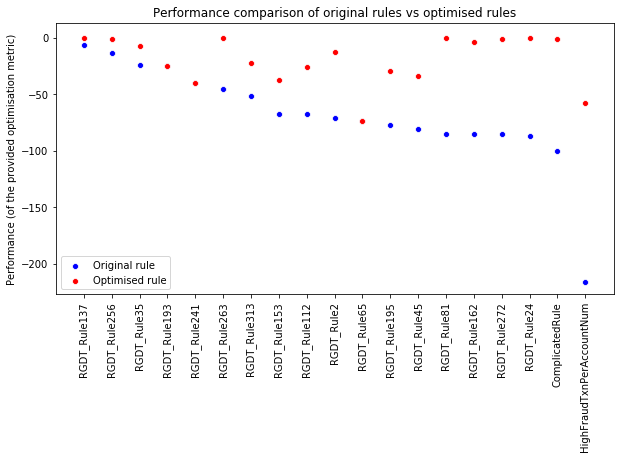

In [20]:
ro.plot_performance_uplift(orig_rule_performances=ro.orig_rule_performances,
                           opt_rule_performances=ro.opt_rule_performances,
                           figsize=(10, 5))

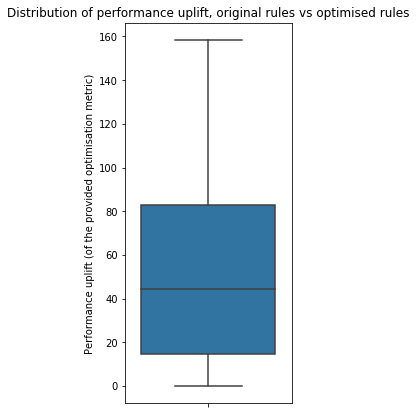

In [21]:
ro.plot_performance_uplift_distribution(orig_rule_performances=ro.orig_rule_performances,
                                        opt_rule_performances=ro.opt_rule_performances,
                                        figsize=(3, 7))

#### On the test set

To visualise the uplift on the test set, we first need to generate the *orig_rule_performances* and *opt_rule_performances* parameters used in the plotting methods as these aren't created as part of the optimisation process. To do this, we need to apply both the original rules and the optimised rules to the test set. **Note that before we apply the original rules, we need to remove those containing features that are missing in *X_train*:**

In [22]:
# Original rules
rules.filter_rules(exclude=ro.rule_names_missing_features)
orig_sys_rule_strings = rules.as_rule_strings(as_numpy=False)
orig_ra = ArgoRuleApplier(rule_strings=orig_sys_rule_strings, 
                          opt_func=apd.fit)
_ = orig_ra.apply(X=X_test)
orig_rule_performances_test = orig_ra.rule_descriptions['OptMetric']

/Users/jlaidler/venvs/rule_optimisation/lib/python3.7/site-packages/rules/convert_system_dicts_to_rule_dicts.py:79: UserWarning: JavaEL : Operator `java_el` is not currently supported in ARGO. Rule cannot be parsed.
  warnings.warn(f'{rule_name} : {e}')


In [23]:
# Optimised rules
opt_ra = ArgoRuleApplier(rule_strings=opt_rule_strings, 
                         opt_func=apd.fit)
_ = opt_ra.apply(X=X_test)
opt_rule_performances_test = opt_ra.rule_descriptions['OptMetric']

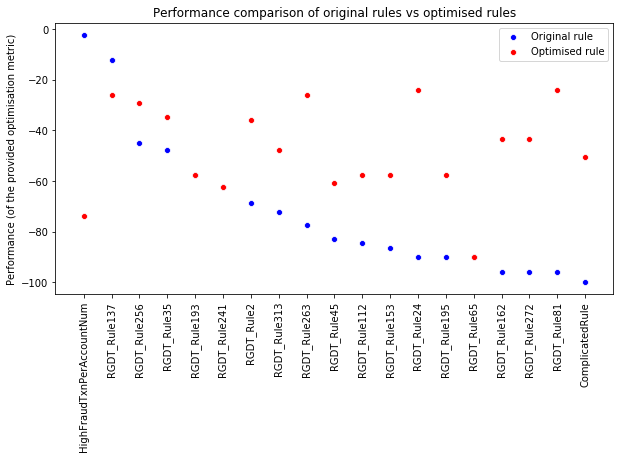

In [24]:
ro.plot_performance_uplift(orig_rule_performances=orig_rule_performances_test,
                           opt_rule_performances=opt_rule_performances_test,
                           figsize=(10, 5))

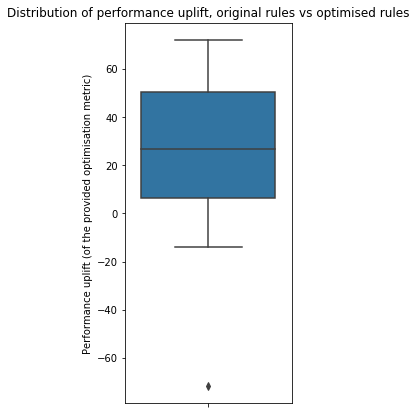

In [25]:
ro.plot_performance_uplift_distribution(orig_rule_performances=orig_rule_performances_test,
                                        opt_rule_performances=opt_rule_performances_test,
                                        figsize=(3, 7))

----

## The End

That's it folks - if you have any queries or suggestions please put them in the *#sim-datatools-help* Slack channel or email James directly.